In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

In [3]:
#Функция кросс-валидации
def cross_validation(model, train, features, target='price_doc'):
    msle_list = []
    #mse_list = []

    kf = KFold(n_splits=5, shuffle = True)
    for i, (train_index, val_index) in enumerate(kf.split(train)):
        train_part = train.loc[train_index, : ]
        val_part = train.loc[val_index,:  ]

        #model = SGDRegressor()
        #model.fit( X=train_part[features], y = target ) #model.fit( X=features.fillna(0), y = target )
        #val_prediction = model.predict( val_part[features].fillna(0) ).clip( 0, 1000000000)
        model.fit( X=train_part[features], y = train_part[target] )
        val_prediction = model.predict( val_part[features].fillna(0) ).clip( 0, 1000000000)


        #mse = mean_squared_error(val_prediction,  val_part[target]  )
        msle = mean_squared_log_error(val_prediction,  val_part[target]  )


        msle_list.append(msle)
        #mse_list.append(mse)
        print( f'Fold {i}: msle {msle}')



    print( f'MSLE average = {np.mean(msle_list)} , std ={np.std(msle_list)}  '  )

#Функция для создания csv файла для сабмишшна
def prepare_submission(submission_name, model, train, test, features, target='price_doc'):
    model.fit( X=train[features].fillna(0), y = train[target] )
    test_prediction = model.predict( test[features].fillna(0) )
    sample_submission = pd.read_csv('sample_submission.csv')
    sample_submission['price_doc']= test_prediction
    sample_submission['price_doc'] = sample_submission['price_doc'].clip( 1, 1000000000) 
    sample_submission.to_csv(submission_name, index = False)

In [ ]:
#В первой модели будут использованы  непрерывные признаки   ['metro_km_walk', 'kremlin_km', 'full_sq'] с заполненными пропусками

In [4]:
#Смотрю кол-во пропусков
print(train[['price_doc','metro_km_walk','kremlin_km', 'full_sq']].isna().sum())
print(test[['metro_km_walk','kremlin_km', 'full_sq']].isna().sum())

price_doc         0
metro_km_walk    25
kremlin_km        0
full_sq           0
dtype: int64
metro_km_walk    34
kremlin_km        0
full_sq           0
dtype: int64


In [5]:
print(train['metro_km_walk'].median())
print(train['metro_km_walk'].mean())
#сравниваю значения среднего и меидианы, они сильно отличаются, поэтому беру медианное значение

1.703934087
3.561466753071809


In [6]:
#Заменяю пропуски фичи 'metro_km_walk' на медианные значения 
train['metro_km_walk'] = train['metro_km_walk'].fillna(train['metro_km_walk'].median()).clip( 0, 1000000000)
test['metro_km_walk'] = test['metro_km_walk'].fillna(test['metro_km_walk'].median()).clip( 0, 1000000000)

In [7]:
cross_validation(model=SGDRegressor(), train=train, features=['metro_km_walk','kremlin_km', 'full_sq'])
#MSLE average = 52.8

Fold 0: msle 25.92463323895243
Fold 1: msle 0.6743981568692863
Fold 2: msle 109.94948242183445
Fold 3: msle 9.464134941840475
Fold 4: msle 118.09364408350412
MSLE average = 52.82125856860015 , std =50.68862189000921  


In [9]:
features = ['metro_km_walk', 'kremlin_km', 'full_sq']

prepare_submission(submission_name='predict1.csv', model=SGDRegressor(), train=train, test=test, features=features)
#score on kaggle predict1.csv: 9.61487

In [10]:
#Во второй модели нормирую признаки из первой модели (std=1, mean = 0)

features = ['metro_km_walk', 'kremlin_km', 'full_sq']
StandScaler = StandardScaler()

StandScaler.fit(train[features])
train[features] = StandScaler.transform(train[features])
test[features] = StandScaler.transform(test[features])

In [11]:
cross_validation(model=SGDRegressor(), train=train, features=['metro_km_walk','kremlin_km', 'full_sq'])
#MSLE average = 9.0

Fold 0: msle 0.3020659104483603
Fold 1: msle 0.3684036173557443
Fold 2: msle 42.30974321656227
Fold 3: msle 0.7020164984369287
Fold 4: msle 1.4165333128188315
MSLE average = 9.019752511124427 , std =16.64969100657246  


In [12]:
features = ['metro_km_walk', 'kremlin_km', 'full_sq']

prepare_submission(submission_name='predict2.csv', model=SGDRegressor(), train=train, test=test, features=features)
#score on kaggle predict2.csv: 0.45086
#при нормировании стало значительно лучше


In [ ]:
#В модель 3 добавлю категориальные признаки ['product_type' , 'material']

In [13]:
train['product_type'].value_counts()

Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64

In [14]:
train['product_type'] = train['product_type'].replace( { 'Investment':1,'OwnerOccupier':0  })
test['product_type'] = test['product_type'].replace( { 'Investment':1,'OwnerOccupier':0  })

In [15]:
print(train['material'].isna().sum())
print(test['material'].isna().sum())

9572
0


In [16]:
train['material'] = train['material'].fillna(0)

In [17]:
train['material'].value_counts()

1.0    14197
0.0     9572
2.0     2993
5.0     1561
4.0     1344
6.0      803
3.0        1
Name: material, dtype: int64

In [18]:
test['material'].value_counts()

1    5241
2     958
4     619
5     487
6     356
3       1
Name: material, dtype: int64

In [19]:
features=['metro_km_walk','kremlin_km', 'full_sq', 'product_type', 'material']
cross_validation(model=SGDRegressor(), train=train, features=features)
#MSLE average = 3.4

Fold 0: msle 14.218205527900002
Fold 1: msle 1.1885589122072397
Fold 2: msle 0.67734283173453
Fold 3: msle 0.35617598746852824
Fold 4: msle 0.4496832005002068
MSLE average = 3.3779932919621016 , std =5.427775178565378  


In [20]:
features = ['metro_km_walk', 'kremlin_km', 'full_sq', 'product_type', 'material']

prepare_submission(submission_name='predict3.csv', model=SGDRegressor(), train=train, test=test, features=features)
#score on kaggle predict3.csv: 0.40167
#при добавлении категориальных фичей ['product_type', 'material'] стало немного лучше

In [ ]:
#В модель 4 добавлю фичи год и месяц

In [21]:
train['month'] = pd.to_datetime(train['timestamp']).dt.month
train['year'] = pd.to_datetime(train['timestamp']).dt.year
test['month'] = pd.to_datetime(test['timestamp']).dt.month
test['year'] = pd.to_datetime(test['timestamp']).dt.year

In [127]:
train[['metro_km_walk','kremlin_km', 'full_sq', 'product_type', 'material', 'month', 'year']]

,metro_km_walk,kremlin_km,full_sq,product_type,material,month,year
0,-0.420694,-0.105261,-0.294873,1,0.0,8,2011
1,-0.506646,-0.870280,-0.531523,1,0.0,8,2011
2,-0.366182,-0.826471,-0.294873,1,0.0,8,2011
3,-0.449701,0.407755,0.914671,1,0.0,9,2011
4,-0.497326,-1.595169,0.599138,1,0.0,9,2011
...,...,...,...,...,...,...,...
30466,-0.498888,-0.408148,-0.268578,1,1.0,6,2015
30467,-0.481328,-1.513360,0.835788,1,2.0,6,2015
30468,-0.318326,0.694279,-0.242284,0,1.0,6,2015
30469,-0.262016,-0.286933,0.257310,1,1.0,6,2015


In [22]:
features = ['month', 'year']
StandScaler = StandardScaler()

StandScaler.fit(train[features])
train[features] = StandScaler.transform(train[features])
test[features] = StandScaler.transform(test[features])

In [23]:
features=['metro_km_walk','kremlin_km', 'full_sq', 'product_type', 'material', 'month', 'year']
cross_validation(model=SGDRegressor(), train=train, features=features)
#MSLE average = 1.0

Fold 0: msle 0.6115000442207807
Fold 1: msle 0.8073391647577653
Fold 2: msle 2.5607038573622067
Fold 3: msle 0.29278127578185575
Fold 4: msle 0.718524720282402
MSLE average = 0.9981698124810021 , std =0.8004020055580856  


In [24]:
features = ['metro_km_walk','kremlin_km', 'full_sq', 'product_type', 'material', 'month', 'year']

prepare_submission(submission_name='predict4.csv', model=SGDRegressor(), train=train, test=test, features=features)
#score on kaggle predict4.csv: 0.44560
#при добавлении datetime фичей ['month', 'year'] результат на kaggle стал немного хуже, хотя результат на кросс-валидации стал лучше

In [25]:
#В модели 5 добавлю фичу 'build_year'
print(train['build_year'].isna().sum())
print(test['build_year'].isna().sum())

13605
1049


In [26]:
train['build_year'] = train['build_year'].fillna(train['build_year'].median()).clip( 0, 1000000000)
test['build_year'] = test['build_year'].fillna(test['build_year'].median()).clip( 0, 1000000000)

In [27]:
features = ['build_year']
StandScaler = StandardScaler()

StandScaler.fit(train[features])
train[features] = StandScaler.transform(train[features])
test[features] = StandScaler.transform(test[features])

In [28]:
features=['metro_km_walk','kremlin_km', 'full_sq', 'product_type', 'material', 'month', 'year', 'build_year']
cross_validation(model=SGDRegressor(), train=train, features=features)
#MSLE average = 44.8

Fold 0: msle 44.20371069492763
Fold 1: msle 48.46403930505048
Fold 2: msle 67.49668063824198
Fold 3: msle 0.6737469111357118
Fold 4: msle 63.05822324831575
MSLE average = 44.77928015953431 , std =23.70403694836618  


In [29]:
features = ['metro_km_walk','kremlin_km', 'full_sq', 'product_type', 'material', 'month', 'year', 'build_year']

prepare_submission(submission_name='predict5.csv', model=SGDRegressor(), train=train, test=test, features=features)
#score on kaggle predict5.csv: 4.49287
#при добавлениия фичи 'build_year' результат стал ещё немного хуже и на кросс-валидации, и на kaggle

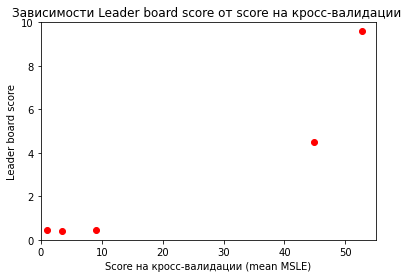

In [32]:
#График зависимоти 
plt.plot([52.8, 9.0, 3.4, 1.0, 44.8], [9.61, 0.45, 0.40, 0.45, 4.49], 'ro')
plt.axis([0, 55, 0, 10])
plt.xlabel('Score на кросс-валидации (mean MSLE)')
plt.ylabel('Leader board score')
plt.title('Зависимости Leader board score от score на кросс-валидации ')
plt.show()

In [ ]:
'''
Отчёт:

1) Модель 1 с фичами ['metro_km_walk','kremlin_km', 'full_sq'] показала самый плохой результат: mean MSLE = 52.8 (std=50.7),
score on kaggle = 9.6. 
2) Однако, простое нормирование (mean=0, std=1) признаков в модели 1 значительно снижает ошибку. Таким образом,
в модели 2 показатели следующие: mean MSLE = 9.0 (std =16.7), score on kaggle=0.45. 
3) Далее в модель были добавлены категориальные фичи ['product_type' , 'material']. Благодаря ним удалось примерно в 3 раза
сократить ошибку и стандартное отклонение на кросс-валидации. Показатели модели 3: mean MSLE=3.4 (std=5.4), score on kaggle=0.40. 
4) В модель 4 были добавлены нормированные фичи Год и Месяц. Их добавление в модель ещё снизило ошибку и стандартное отклонение на кросс-валидации (mean MSLE=1.0,std =0.8), однако 
немного ухудшило score на kaggle (0.45). 
5) В модель 5 была добавлена нормированная фича 'build_year', которая значительно увеличила ошибку и стандартно отклонение
на кросс-валидации, а также ухудшило score на kaggle: mean MSLE=44.8 (std=23.7), score on kaggle=4.5
    
Выводы:
- нормирование фичей значительно снижает ошибку
- добавление всех фичей выше, кроме 'build_year', улучшало результат. Либо 'build_year' не влияет на предсказание target значения, 
    либо эту фичу необходимо ещё пробразовать, например сделать из неё категориальную фичу (период строительства сталинских домов, хрущёвок,
    дома в современной Росии и т.п.)
'''